In [1]:
%pip install gdown
%pip install lightgbm
import gdown
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


['/content/Dataset/test.csv',
 '/content/Dataset/train.csv',
 '/content/Dataset/training.csv']

**LightGBM with label-encoding**

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.583764	valid_1's multi_logloss: 0.624621
[20]	training's multi_logloss: 0.411902	valid_1's multi_logloss: 0.464603
[30]	training's multi_logloss: 0.332137	valid_1's multi_logloss: 0.396168
[40]	training's multi_logloss: 0.290523	valid_1's multi_logloss: 0.363257
[50]	training's multi_logloss: 0.263624	valid_1's multi_logloss: 0.34694
[60]	training's multi_logloss: 0.242032	valid_1's multi_logloss: 0.3372
[70]	training's multi_logloss: 0.225539	valid_1's multi_logloss: 0.331897
[80]	training's multi_logloss: 0.211834	valid_1's multi_logloss: 0.329
[90]	training's multi_logloss: 0.198727	valid_1's multi_logloss: 0.326533
[100]	training's multi_logloss: 0.188145	valid_1's multi_logloss: 0.325254
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.188145	valid_1's multi_logloss: 0.325254




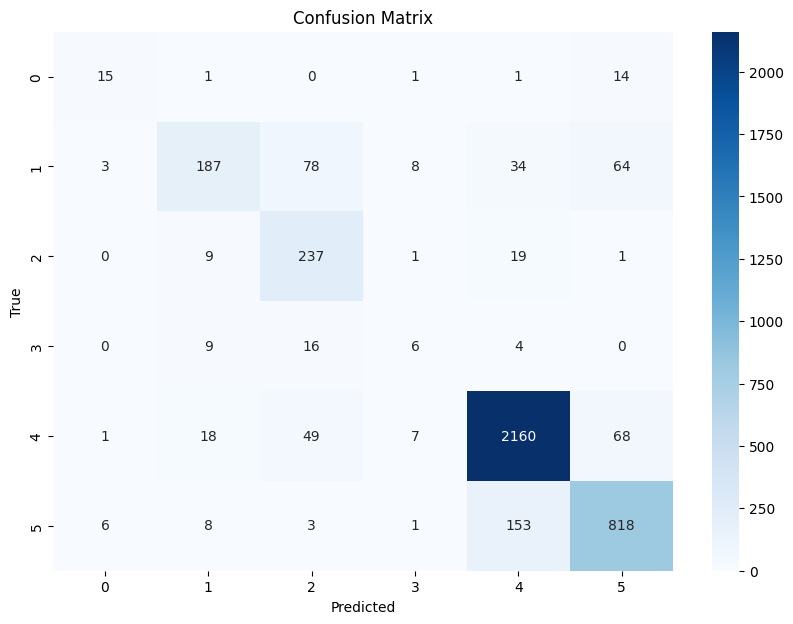

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        32
           1       0.81      0.50      0.62       374
           2       0.62      0.89      0.73       267
           3       0.25      0.17      0.20        35
           4       0.91      0.94      0.92      2303
           5       0.85      0.83      0.84       989

    accuracy                           0.86      4000
   macro avg       0.67      0.63      0.64      4000
weighted avg       0.86      0.86      0.85      4000



In [13]:
# data preprocessing with Label encoding

X = pd.read_csv("Dataset/train.csv", sep=';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# remove column with 80% null values
X.drop('Cross_Street', axis=1)

# handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# data handling
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

def label_encoding_column(df, column):
    lab_encoder = LabelEncoder()
    df[column] = lab_encoder.fit_transform(df[column])
    return df

for col in categorical_columns:
  if col == 'Modus_Operandi':
    continue
  X = label_encoding_column(X, col)

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x:x[0])
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
  ])




# 2. Separating features and target
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check and convert the target column to numeric if necessary
if y_train.dtype == 'object':
    y_train = y_train.astype('category').cat.codes  # Converts to numeric based on category codes
if y_test.dtype == 'object':
    y_test = y_test.astype('category').cat.codes  # Same for the test set

# 3. Encoding categorical columns with handling for unseen values
categorical_columns = ['Location', 'Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
                       'Premise_Description', 'Weapon_Description', 'Status', 'Status_Description']

for col in categorical_columns:
    # Create a unique mapping of values for the training set
    unique_vals = X_train[col].astype(str).unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}

    # Apply the mapping to the training set
    X_train[col] = X_train[col].astype(str).map(mapping)

    # Apply the mapping to the test set, handling unseen values
    X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)

# 4. Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 5. Create LightGBM Dataset
train_set = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_set = lgb.Dataset(X_val, label=y_val, reference=train_set, free_raw_data=False)

# 6. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1
}

# 7. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, val_set],  # Add both the training and validation sets
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
)

# 8. Predictions on the test set
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)  # Probabilities for each class

# 9. Final predictions (for multiclass classification, get the class with the highest probability)
y_pred_classes = y_pred_proba.argmax(axis=1)

# 10. Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 11. Classification report (precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)

**LightGBM with one-hot-encoding**

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.585918	valid_1's multi_logloss: 0.616575
[20]	training's multi_logloss: 0.416273	valid_1's multi_logloss: 0.455815
[30]	training's multi_logloss: 0.339429	valid_1's multi_logloss: 0.387588
[40]	training's multi_logloss: 0.299481	valid_1's multi_logloss: 0.356753
[50]	training's multi_logloss: 0.276086	valid_1's multi_logloss: 0.340732
[60]	training's multi_logloss: 0.260296	valid_1's multi_logloss: 0.331594
[70]	training's multi_logloss: 0.248834	valid_1's multi_logloss: 0.326794
[80]	training's multi_logloss: 0.238303	valid_1's multi_logloss: 0.324416
[90]	training's multi_logloss: 0.229583	valid_1's multi_logloss: 0.322991
[100]	training's multi_logloss: 0.222242	valid_1's multi_logloss: 0.322433
Did not meet early stopping. Best iteration is:
[99]	training's multi_logloss: 0.222826	valid_1's multi_logloss: 0.322301




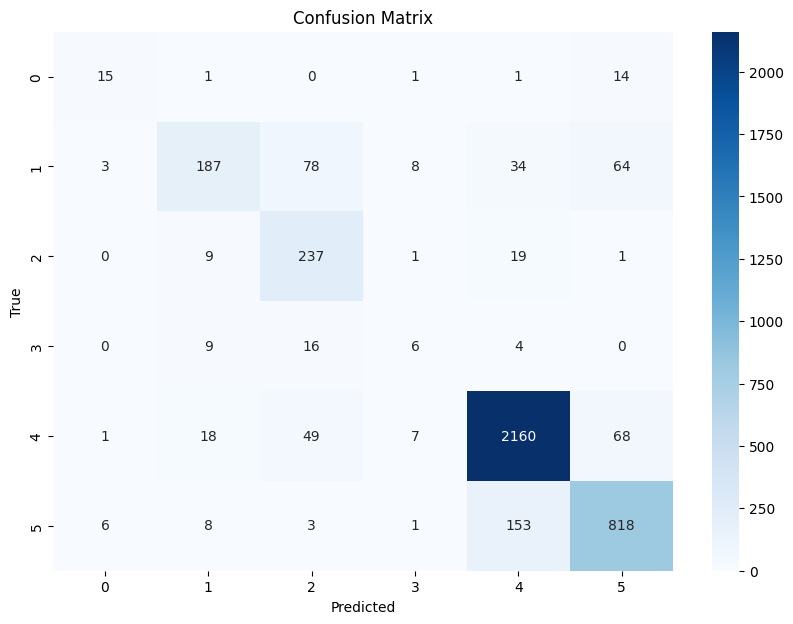

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.60        32
           1       0.79      0.56      0.66       374
           2       0.73      0.85      0.78       267
           3       0.25      0.06      0.09        35
           4       0.94      0.94      0.94      2303
           5       0.84      0.93      0.88       989

    accuracy                           0.88      4000
   macro avg       0.69      0.66      0.66      4000
weighted avg       0.88      0.88      0.88      4000



In [12]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# data preprocessing with OneHot encoding

X = pd.read_csv("Dataset/train.csv", sep=';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# remove column with 80% null values
X = X.drop('Cross_Street', axis=1)

# handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# data handling
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col != 'Modus_Operandi']

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x:x[0])
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
  ])

# 2. Separating features and target
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check and convert the target column to numeric if necessary
if y_train.dtype == 'object':
    y_train = y_train.astype('category').cat.codes  # Converts to numeric based on category codes
if y_test.dtype == 'object':
    y_test = y_test.astype('category').cat.codes  # Same for the test set

# 3. One-Hot Encoding of categorical columns
categorical_columns = ['Location', 'Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
                       'Premise_Description', 'Weapon_Description', 'Status', 'Status_Description']

# One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Aligning the columns of train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Remove any duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Rename columns to avoid special characters
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Verify again for duplicates
assert X_train.columns.duplicated().sum() == 0, "There are still duplicated columns in X_train after removal attempt!"
assert X_test.columns.duplicated().sum() == 0, "There are still duplicated columns in X_test after removal attempt!"

# Create the training and validation set split (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Align columns of train, validation, and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Remove any duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_val = X_val.loc[:, ~X_val.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# 4. Convert target to numeric
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

# 5. Create the LightGBM Dataset
train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

# 6. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1
}

# 7. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, val_set],  # Add both the training and validation sets
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
)

# 8. Predictions
y_pred_proba = bst.predict(X_test)
y_pred_classes = y_pred_proba.argmax(axis=1)

# 9. Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. Classification report (precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)